In [ ]:
## Standard libraries
import os
import json
import math
import numpy as np
from scipy import spatial

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch Data Loading
import torch
import torch.utils.data as data
import torchvision
from torchvision.datasets import CIFAR10

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial9_jax"

print("Device:", jax.devices()[0])

In [7]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random
import flax.linen as nn
from flax.training import train_state
import optax
import numpy as np
from typing import Any, Callable, Sequence
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import cv2

class CNNAutoencoder(nn.Module):
    """Simple CNN Autoencoder for MNIST"""
    
    @nn.compact
    def __call__(self, x):
        # Encoder
        x = nn.Conv(features=32, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))  # 28x28 -> 14x14
        
        x = nn.Conv(features=64, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))  # 14x14 -> 7x7
        
        x = nn.Conv(features=128, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.relu(x)
        encoded = x  # Bottleneck: 7x7x128
        
        # Decoder - using ConvTranspose with careful size matching
        x = nn.ConvTranspose(features=64, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(encoded)
        x = nn.relu(x)  # 7x7 -> 14x14
        
        x = nn.ConvTranspose(features=32, kernel_size=(3, 3), strides=(2, 2), padding='SAME')(x)
        x = nn.relu(x)  # 14x14 -> 28x28
        
        # Output layer
        x = nn.Conv(features=1, kernel_size=(3, 3), padding='SAME')(x)
        decoded = nn.sigmoid(x)  # 28x28x1
        
        return decoded, encoded

class ActivationMaximizer:
    """JAX implementation of activation maximization for CNN feature visualization"""
    
    def __init__(self, model, params):
        self.model = model
        self.params = params
        
    def get_activations(self, params, x, target_layer='encoded'):
        """Get activations from target layer"""
        decoded, encoded = self.model.apply(params, x)
        if target_layer == 'encoded':
            return encoded
        elif target_layer == 'decoded':
            return decoded
        else:
            raise ValueError(f"Unknown target layer: {target_layer}")
    
    def compute_activation_loss(self, x, params, target_layer, unit_idx):
        """Compute loss for maximizing specific unit activation"""
        activations = self.get_activations(params, x, target_layer)
        
        # For encoded features (batch, height, width, channels)
        if target_layer == 'encoded':
            if len(unit_idx) == 3:  # (h, w, c)
                h, w, c = unit_idx
                return -activations[0, h, w, c]  # Negative because we want to maximize
            elif len(unit_idx) == 1:  # Just channel
                c = unit_idx[0]
                return -jnp.mean(activations[0, :, :, c])
        
        return -jnp.mean(activations)
    
    def gradient_step(self, x, params, target_layer, unit_idx, learning_rate=0.1):
        """Single gradient step for activation maximization"""
        loss_fn = lambda img: self.compute_activation_loss(img, params, target_layer, unit_idx)
        grad_fn = grad(loss_fn)
        gradients = grad_fn(x)
        
        # Gradient ascent (negative gradient descent)
        x_new = x - learning_rate * gradients
        return x_new, gradients
    
    def l2_regularization(self, x, decay_rate=0.01):
        """Apply L2 decay regularization"""
        return x * (1.0 - decay_rate)
    
    def gaussian_blur_regularization(self, x, sigma=1.0):
        """Apply Gaussian blur regularization"""
        # Convert to numpy for scipy processing
        x_np = np.array(x[0])  # Remove batch dimension
        
        # Apply Gaussian filter to each channel
        if len(x_np.shape) == 3:  # (H, W, C)
            blurred = np.zeros_like(x_np)
            for c in range(x_np.shape[-1]):
                blurred[:, :, c] = gaussian_filter(x_np[:, :, c], sigma)
        else:  # (H, W) - single channel
            blurred = gaussian_filter(x_np, sigma)
        
        return jnp.expand_dims(jnp.array(blurred), 0)  # Add batch dimension back
    
    def norm_crop_regularization(self, x, threshold_percentile=30):
        """Crop pixels with low norm contribution"""
        # Compute norm across channels
        if len(x.shape) == 4:  # (B, H, W, C)
            norm = jnp.linalg.norm(x[0], axis=-1)  # (H, W)
        else:
            norm = jnp.linalg.norm(x[0], axis=0)
        
        # Find threshold
        threshold = jnp.percentile(norm, threshold_percentile)
        
        # Create mask
        mask = norm >= threshold
        if len(x.shape) == 4:
            mask = jnp.expand_dims(mask, axis=-1)  # Add channel dimension
            mask = jnp.expand_dims(mask, axis=0)   # Add batch dimension
        
        return x * mask
    
    def abs_contrib_crop_regularization(self, x, threshold_percentile=30):
        """Crop pixels with low absolute contribution"""
        abs_x = jnp.abs(x)
        threshold = jnp.percentile(abs_x, threshold_percentile)
        mask = abs_x >= threshold
        return x * mask
    
    def optimize_activation(self, 
                          target_layer='encoded',
                          unit_idx=(0,),
                          steps=100,
                          learning_rate=0.1,
                          input_shape=(1, 28, 28, 1),
                          use_random_init=True,
                          l2_decay=True,
                          l2_decay_rate=0.01,
                          gaussian_blur=True,
                          blur_every=10,
                          blur_sigma=1.0,
                          norm_crop=False,
                          norm_crop_threshold=30,
                          contrib_crop=False,
                          contrib_crop_threshold=30,
                          verbose=True,
                          generate_frames=False):
        """
        Optimize input to maximize activation of target unit
        
        Args:
            target_layer: Layer to target ('encoded' or 'decoded')
            unit_idx: Index of unit to maximize (tuple)
            steps: Number of optimization steps
            learning_rate: Learning rate for gradient ascent
            input_shape: Shape of input image
            use_random_init: Whether to use random initialization
            l2_decay: Apply L2 regularization
            l2_decay_rate: L2 decay rate
            gaussian_blur: Apply Gaussian blur regularization
            blur_every: Apply blur every N steps
            blur_sigma: Sigma for Gaussian blur
            norm_crop: Apply norm-based cropping
            norm_crop_threshold: Percentile threshold for norm cropping
            contrib_crop: Apply contribution-based cropping
            contrib_crop_threshold: Percentile threshold for contribution cropping
            verbose: Print progress
            generate_frames: Save intermediate frames
        """
        
        # Initialize input
        if use_random_init:
            key = random.PRNGKey(42)
            x = random.normal(key, input_shape) * 0.1
        else:
            x = jnp.zeros(input_shape)
        
        best_activation = -float('inf')
        best_img = x
        frames = [] if generate_frames else None
        
        for step in range(steps):
            # Gradient step
            x, gradients = self.gradient_step(x, self.params, target_layer, unit_idx, learning_rate)
            
            # Apply regularizations
            if l2_decay:
                x = self.l2_regularization(x, l2_decay_rate)
            
            if gaussian_blur and step % blur_every == 0:
                x = self.gaussian_blur_regularization(x, blur_sigma)
            
            if norm_crop:
                x = self.norm_crop_regularization(x, norm_crop_threshold)
            
            if contrib_crop:
                x = self.abs_contrib_crop_regularization(x, contrib_crop_threshold)
            
            # Clip values to reasonable range
            x = jnp.clip(x, -3.0, 3.0)
            
            # Check current activation
            current_activation = -self.compute_activation_loss(x, self.params, target_layer, unit_idx)
            
            if current_activation > best_activation:
                best_activation = current_activation
                best_img = x
            
            if verbose and step % 10 == 0:
                print(f"Step {step}: Activation = {current_activation:.4f}")
            
            if generate_frames:
                frames.append(np.array(x[0, :, :, 0]))  # Store as numpy array
        
        result = {
            'optimized_image': best_img,
            'final_image': x,
            'best_activation': best_activation,
            'final_activation': -self.compute_activation_loss(x, self.params, target_layer, unit_idx)
        }
        
        if generate_frames:
            result['frames'] = frames
            
        return result

def load_mnist_data():
    """Load and preprocess MNIST data"""
    try:
        from tensorflow.keras.datasets import mnist
        (x_train, _), (x_test, _) = mnist.load_data()
    except ImportError:
        print("TensorFlow not available. Please install it or provide MNIST data manually.")
        return None, None
    
    # Normalize and reshape
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0
    
    # Add channel dimension
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
    
    return x_train, x_test

def train_autoencoder(x_train, x_test, epochs=10, batch_size=128):
    """Train the CNN autoencoder"""
    
    # Initialize model
    model = CNNAutoencoder()
    key = random.PRNGKey(0)
    dummy_input = jnp.ones((1, 28, 28, 1))
    params = model.init(key, dummy_input)
    
    # Initialize optimizer
    optimizer = optax.adam(learning_rate=1e-3)
    state = train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer
    )
    
    # Training step
    @jit
    def train_step(state, batch):
        def loss_fn_L2(params):
            decoded, _ = model.apply(params, batch)
            return jnp.mean((batch - decoded) ** 2)
        
        loss, gradients = jax.value_and_grad(loss_fn_L2)(state.params)
        state = state.apply_gradients(grads=gradients)
        return state, loss
    
    # Training loop
    num_batches = len(x_train) // batch_size
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        # Shuffle data
        key = random.PRNGKey(epoch)
        indices = random.permutation(key, len(x_train))
        x_train_shuffled = x_train[indices]
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = start_idx + batch_size
            batch = x_train_shuffled[start_idx:end_idx]
            
            state, loss = train_step(state, batch)
            epoch_loss += loss
        
        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch+1}/{epochs}: Loss = {avg_loss:.4f}")
    
    return model, state.params

def visualize_results(results, save_path=None):
    """Visualize optimization results"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    # Original optimized image
    img = results['optimized_image'][0, :, :, 0]
    axes[0, 0].imshow(img, cmap='gray')
    axes[0, 0].set_title(f"Best Image (Activation: {results['best_activation']:.4f})")
    axes[0, 0].axis('off')
    
    # Final image
    final_img = results['final_image'][0, :, :, 0]
    axes[0, 1].imshow(final_img, cmap='gray')
    axes[0, 1].set_title(f"Final Image (Activation: {results['final_activation']:.4f})")
    axes[0, 1].axis('off')
    
    # Difference
    diff = np.abs(img - final_img)
    axes[1, 0].imshow(diff, cmap='hot')
    axes[1, 0].set_title("Absolute Difference")
    axes[1, 0].axis('off')
    
    # Histogram of pixel values
    axes[1, 1].hist(img.flatten(), bins=50, alpha=0.7, label='Best Image')
    axes[1, 1].hist(final_img.flatten(), bins=50, alpha=0.7, label='Final Image')
    axes[1, 1].set_title("Pixel Value Distribution")
    axes[1, 1].legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def create_activation_gif(frames, save_path='activation_optimization.gif'):
    """Create GIF from optimization frames"""
    if not frames:
        print("No frames to create GIF")
        return
    
    import imageio
    
    # Normalize frames for visualization
    normalized_frames = []
    for frame in frames:
        # Normalize to 0-255 range
        normalized = ((frame - frame.min()) / (frame.max() - frame.min()) * 255).astype(np.uint8)
        normalized_frames.append(normalized)
    
    # Save as GIF
    imageio.mimsave(save_path, normalized_frames, duration=0.1)
    print(f"GIF saved as {save_path}")

# Example usage
def main():
    """Main function demonstrating the activation maximization"""
    
    print("Loading MNIST data...")
    x_train, x_test = load_mnist_data()
    
    if x_train is None:
        print("Could not load MNIST data. Please ensure TensorFlow is installed.")
        return
    
    print("Training autoencoder...")
    model, params = train_autoencoder(x_train[:1000], x_test[:200], epochs=5)  # Small subset for demo
    
    print("Setting up activation maximizer...")
    maximizer = ActivationMaximizer(model, params)
    
    # Optimize for different units in the encoded layer
    print("Optimizing activation for encoded layer, channel 0...")
    results_ch0 = maximizer.optimize_activation(
        target_layer='encoded',
        unit_idx=(0,),  # Channel 0
        steps=100,
        learning_rate=0.1,
        gaussian_blur=True,
        blur_every=10,
        l2_decay=True,
        generate_frames=True
    )
    
    print("Optimizing activation for encoded layer, channel 31...")
    results_ch31 = maximizer.optimize_activation(
        target_layer='encoded',
        unit_idx=(31,),  # Channel 31
        steps=100,
        learning_rate=0.1,
        gaussian_blur=True,
        blur_every=10,
        l2_decay=True
    )
    
    # Visualize results
    print("Visualizing results...")
    visualize_results(results_ch0, 'activation_max_ch0.png')
    visualize_results(results_ch31, 'activation_max_ch31.png')
    
    # Create GIF if frames were generated
    if 'frames' in results_ch0:
        create_activation_gif(results_ch0['frames'], 'optimization_ch0.gif')
    
    print("Activation maximization complete!")


In [8]:
x_train, x_test = load_mnist_data()

if x_train is None:
    print("Could not load MNIST data. Please ensure TensorFlow is installed.")

In [9]:
print("Training autoencoder...")
model, params = train_autoencoder(x_train[:1000], x_test[:200], epochs=5)  # Small subset for demo
    

Training autoencoder...
Epoch 1/5: Loss = 0.2030
Epoch 2/5: Loss = 0.1286
Epoch 3/5: Loss = 0.1106
Epoch 4/5: Loss = 0.1096
Epoch 5/5: Loss = 0.1095


Loading MNIST data...
Training autoencoder...
Epoch 1/5: Loss = 0.2030
Epoch 2/5: Loss = 0.1286
Epoch 3/5: Loss = 0.1106
Epoch 4/5: Loss = 0.1096
Epoch 5/5: Loss = 0.1095
Setting up activation maximizer...
Optimizing activation for encoded layer, channel 0...
Step 0: Activation = 1.8436
Step 10: Activation = 2.0269
Step 20: Activation = 2.1986
Step 30: Activation = 2.3380
Step 40: Activation = 2.4583
Step 50: Activation = 2.5660
Step 60: Activation = 2.6647
Step 70: Activation = 2.7556
Step 80: Activation = 2.8393
Step 90: Activation = 2.9172
Optimizing activation for encoded layer, channel 31...
Step 0: Activation = 1.1739
Step 10: Activation = 1.1699
Step 20: Activation = 1.2131
Step 30: Activation = 1.2617
Step 40: Activation = 1.3095
Step 50: Activation = 1.3552
Step 60: Activation = 1.3987
Step 70: Activation = 1.4409
Step 80: Activation = 1.4820
Step 90: Activation = 1.5216
Visualizing results...


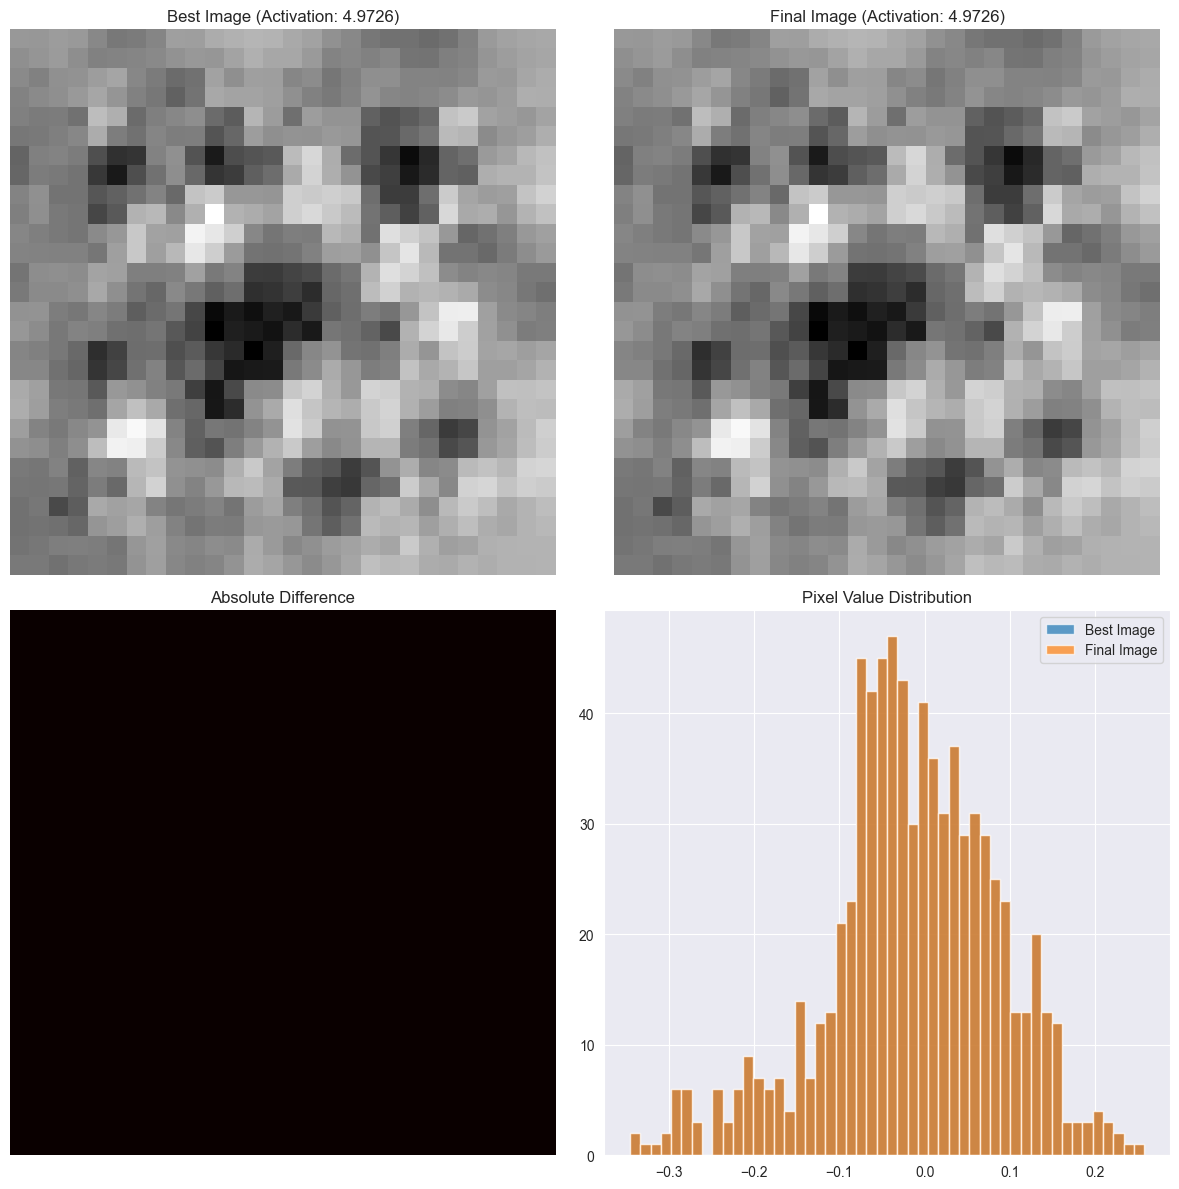

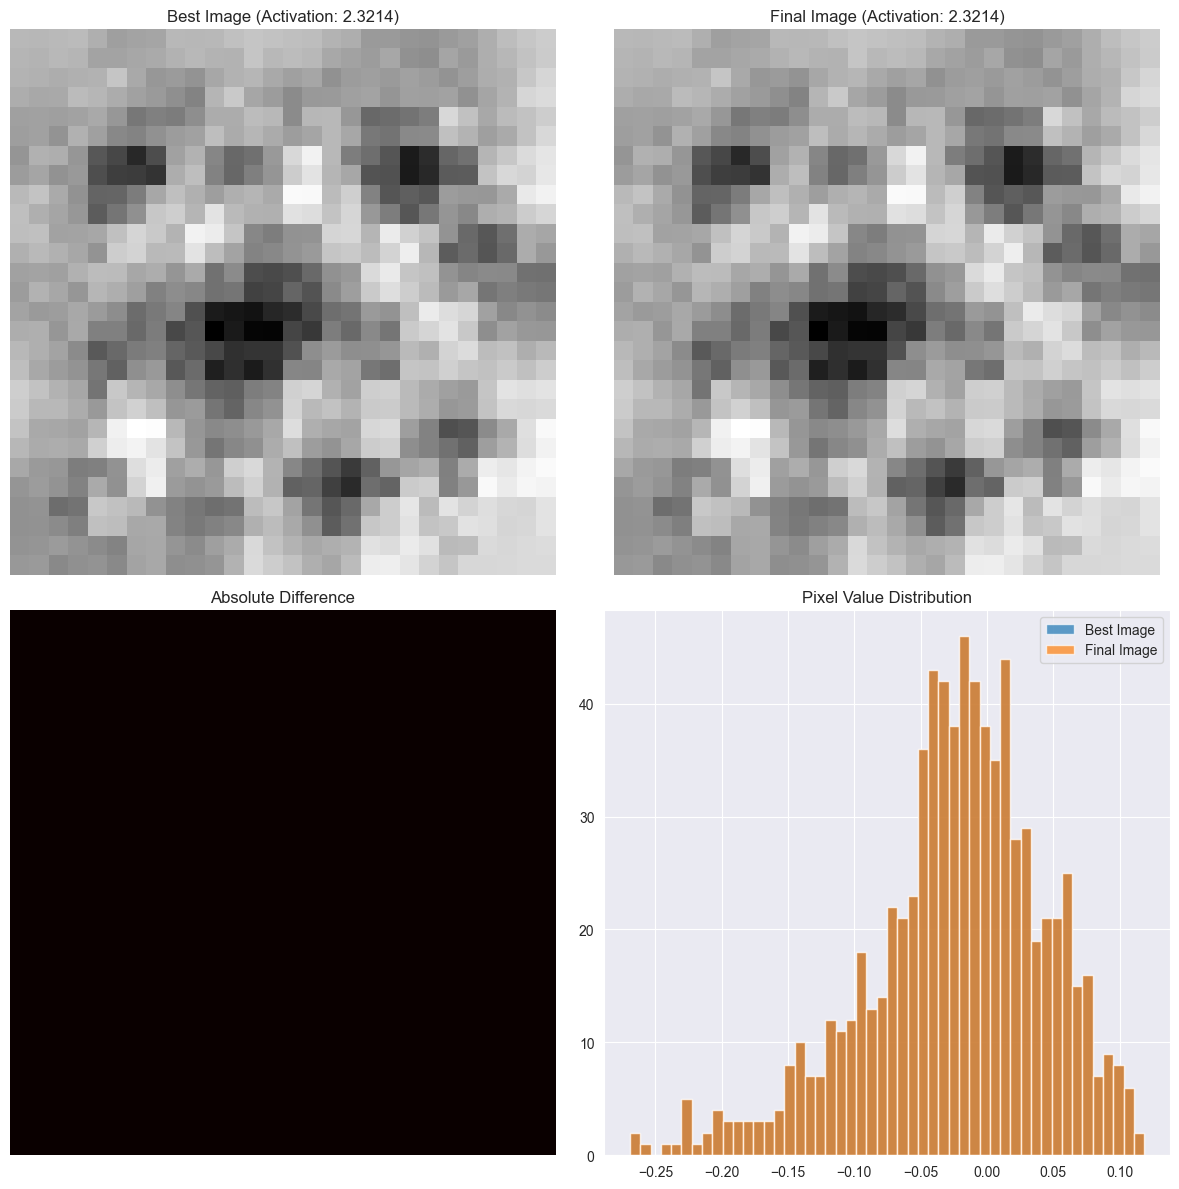

GIF saved as optimization_ch0.gif
Activation maximization complete!


In [11]:
main()